In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pynlo_peter import Fiber_PPLN_NLSE as fpn
import scipy.constants as sc
import clipboard_and_style_sheet
from scipy.interpolate import interp1d

clipboard_and_style_sheet.style_sheet()


class MFD:
    def __init__(self):
        mfd_data = np.genfromtxt("../SM_INF3_MFD.txt")
        self.wl_um = mfd_data[:, 0]
        self.mfd = mfd_data[:, 1]

        self.grid = interp1d(self.wl_um, self.mfd, 'cubic', bounds_error=True)


def abcd(a, b, c, d, q):
    return (a * q + b) / (c * q + d)


def waist(q, wl):
    return np.sqrt(1 / (np.imag(-1 / q) * np.pi / wl))


def q_focus(w, wl):
    return (-1j * wl / (np.pi * w ** 2)) ** -1


def lens(q, f):
    return abcd(1, 0, -1 / f, 1, q)


def medium(q, d, n=1.):
    return abcd(1, d / n, 0, 1, q)


def n_ppln(wl_um):
    wl_nm = wl_um * 1e3
    return fpn.DengSellmeier(23.).n(wl_nm)


def abcd_to_oap_input(wl):
    wo_origin = 15.0e-6
    length_ppln = 1.0e-3
    f = sc.inch * 2

    q = q_focus(wo_origin, wl)
    q = medium(q, length_ppln / 2, n_ppln(wl * 1e6))
    q = medium(q, f - length_ppln / 2)
    q = lens(q, sc.inch * 2)
    q = medium(q, 1.3)
    return q


def waist_at_oap_input(wl):
    q = abcd_to_oap_input(wl)
    return waist(q, wl)


def waist_at_fiber_input(wl, f_mm):
    f = f_mm * 1e-3

    q = abcd_to_oap_input(wl)
    q = lens(q, f)
    q = medium(q, f)
    return waist(q, wl)


def waist_at_fiber_output(wl, f_mm):
    f = f_mm * 1e-3
    mfd = MFD().grid(wl * 1e6) * 1e-6
    w = mfd / 2

    q = q_focus(w, wl)
    q = medium(q, f)
    return waist(q, wl)


wl = np.linspace(3e-6, 5e-6, 5000)


Text(0.5, 0.98, 'beam diameter at oap')

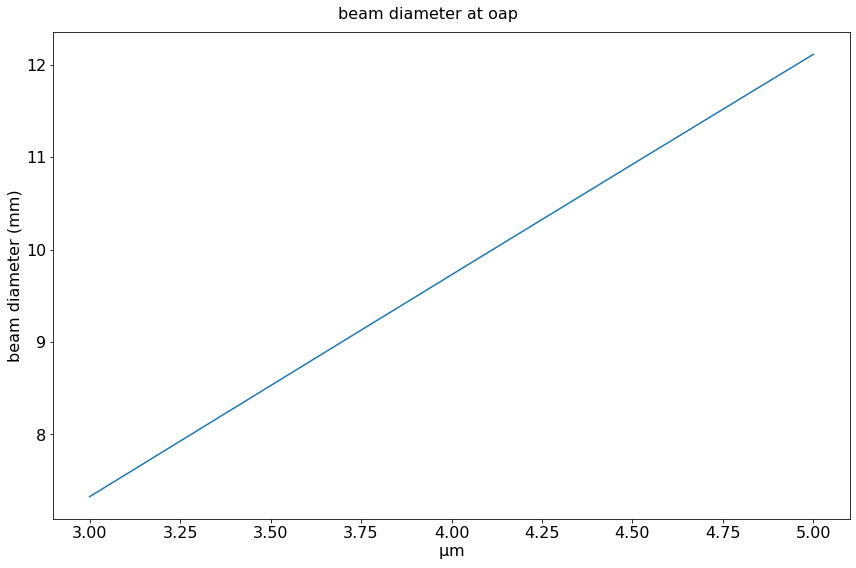

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(wl * 1e6, waist_at_oap_input(wl) * 2e3)
ax.set_xlabel("$\mathrm{\mu m}$")
ax.set_ylabel("beam diameter (mm)")
fig.suptitle("beam diameter at oap")

Text(0.5, 0.98, 'beam diameter at fiber')

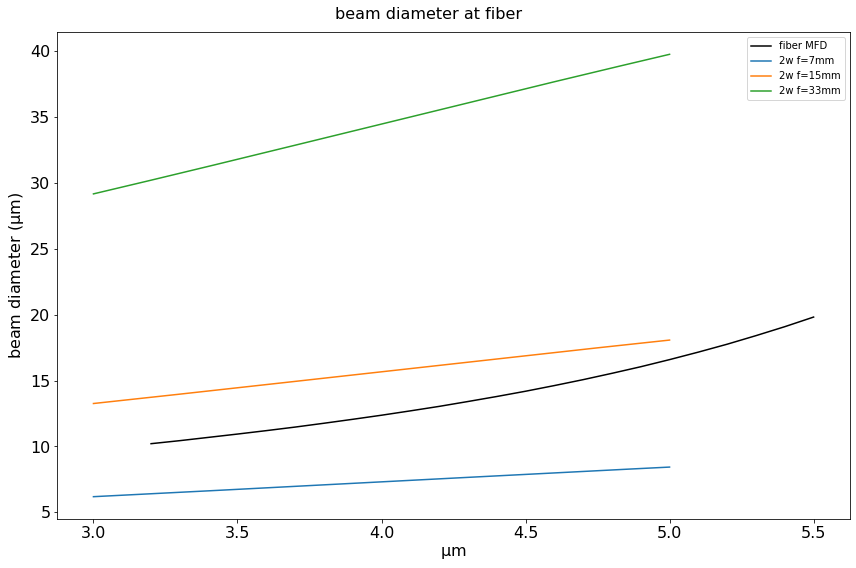

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(MFD().wl_um, MFD().mfd, 'k', label="fiber MFD")
ax.plot(wl * 1e6, waist_at_fiber_input(wl, 7) * 2e6, label="2w f=7mm")
ax.plot(wl * 1e6, waist_at_fiber_input(wl, 15) * 2e6, label="2w f=15mm")
ax.plot(wl * 1e6, waist_at_fiber_input(wl, 33) * 2e6, label="2w f=33mm")
ax.set_xlabel("$\mathrm{\mu m}$")
ax.set_ylabel("beam diameter ($\mathrm{\mu m}$)")
ax.legend(loc='best')
fig.suptitle("beam diameter at fiber")

Text(0.5, 0.98, 'coupling beam diameter error')

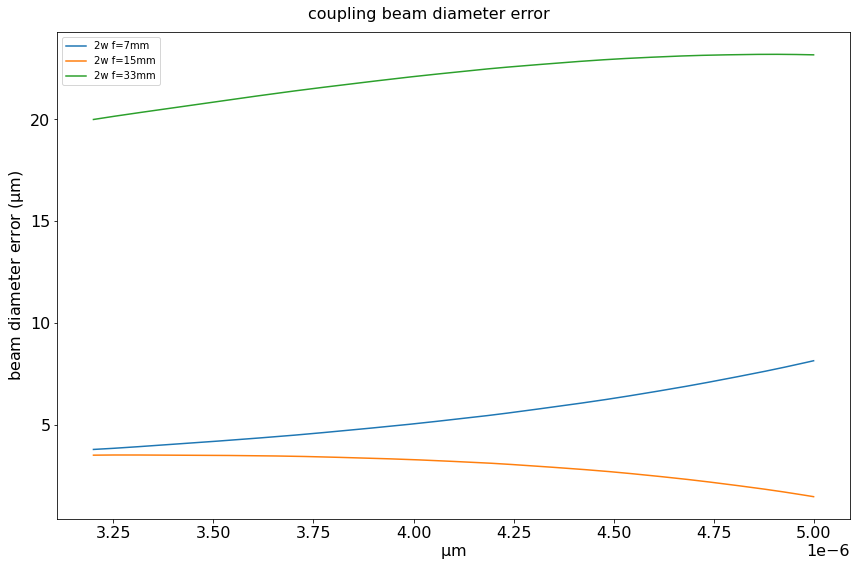

In [5]:
mfd = MFD()
ll, ul = mfd.wl_um[[0, -1]] * 1e-6
ind = np.logical_and(wl >= ll, wl <= ul).nonzero()
wl_sec = wl[ind]
y = mfd.grid(wl_sec * 1e6)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(wl_sec, abs(waist_at_fiber_input(wl_sec, 7) * 2e6 - y),
        label="2w f=7mm")
ax.plot(wl_sec, abs(waist_at_fiber_input(wl_sec, 15) * 2e6 - y),
        label="2w f=15mm")
ax.plot(wl_sec, abs(waist_at_fiber_input(wl_sec, 33) * 2e6 - y),
        label="2w f=33mm")
ax.set_xlabel("$\mathrm{\mu m}$")
ax.set_ylabel("beam diameter error ($\mathrm{\mu m}$)")
ax.legend(loc='best')
fig.suptitle("coupling beam diameter error")


Text(0.5, 0.98, 'fiber output beam diameter')

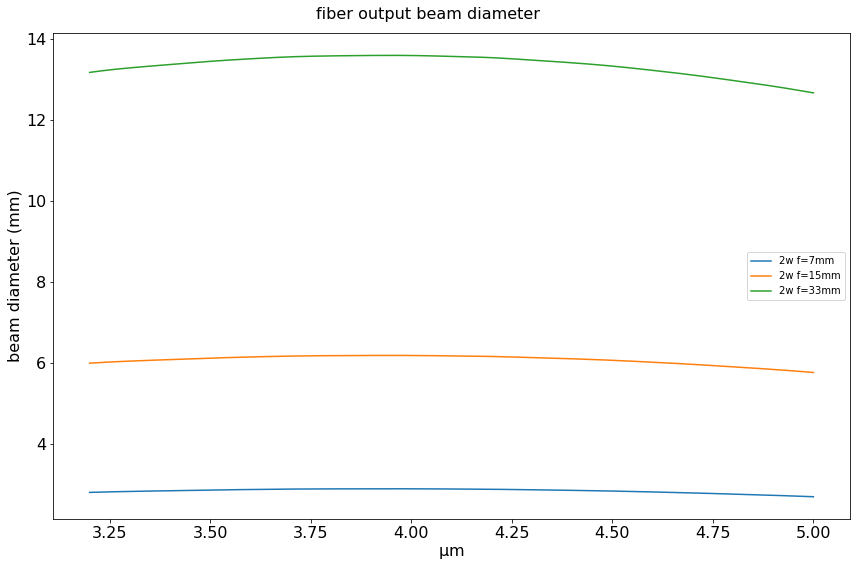

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(wl_sec * 1e6, waist_at_fiber_output(wl_sec, 7) * 2e3, label="2w f=7mm")
ax.plot(wl_sec * 1e6, waist_at_fiber_output(wl_sec, 15) * 2e3,
        label="2w f=15mm")
ax.plot(wl_sec * 1e6, waist_at_fiber_output(wl_sec, 33) * 2e3,
        label="2w f=33mm")
ax.set_xlabel("$\mathrm{\mu m}$")
ax.set_ylabel("beam diameter (mm)")
ax.legend(loc='best')
fig.suptitle("fiber output beam diameter")

Text(0.5, 0.98, 'diffraction limited spot size')

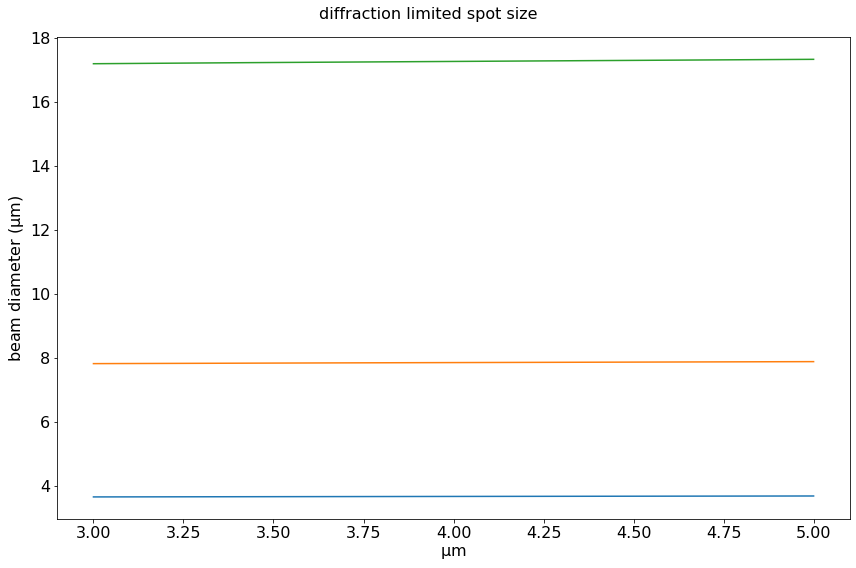

In [7]:
D = waist_at_oap_input(wl) * 2
phi = lambda wl, d, f: 4 * wl * f / (np.pi * d)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(wl * 1e6, phi(wl, D, 7e-3) * 1e6)
ax.plot(wl * 1e6, phi(wl, D, 15e-3) * 1e6)
ax.plot(wl * 1e6, phi(wl, D, 33e-3) * 1e6)
ax.set_xlabel("$\mathrm{\mu m}$")
ax.set_ylabel("beam diameter ($\mathrm{\mu m}$)")
fig.suptitle("diffraction limited spot size")
